# Airbnb New User Bookings - EDA

- My project is to predict where a new Airbnb user will book his/her first travel destination. 

- In this project, I am given a list of users along with their demographics, web session records, and some summary statistics. The goal is to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

- There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

- The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014.

- In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

## Question: Where will the new users book their first reservation?

In [154]:
import os
import sys
import re
import warnings
warnings.filterwarnings("ignore")

import glob

import random
import time
import math
import missingno as msno
import numpy as np
np.random.seed(42)
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('xtick', labelsize = 20) 
plt.rc('ytick', labelsize = 20)
plt.rc('text', usetex = True)
import seaborn as sns
sns.set(font_scale = 1.5)
# allow plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from scipy import stats
import scipy.stats as scs

In [155]:
start = time.time()

In [156]:
train = pd.read_csv('../data/train_users_2.csv.zip')
test = pd.read_csv('../data/test_users.csv.zip')
sessions = pd.read_csv('../data/sessions.csv.zip')
agb = pd.read_csv('../data/age_gender_bkts.csv.zip')
countries = pd.read_csv('../data/countries.csv.zip')

### EDA - train dataset

In [4]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
train.shape
print("There exists {} observations and {} features in train dataset. \n".format(train.shape[0],train.shape[1]))

There exists 213451 observations and 16 features in train dataset. 



In [6]:
# checking the missing value and data type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [7]:
train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [8]:
train.duplicated().sum()

0

### Observations - train dataset

- 'date_first_booking' has missing value.
- 'age' has missing value.
- 'first_affiliate_tracked' has missing value.
- 'date_account_created', 'timestamp_first_active', and 'date_first_booking' have incorrect datatypes.
- 'id' and 'date_first_booking' may not get related info, since I am modeling the location of the fisrt booking only. However, I will keep them until all datasets are investigated.
- 'country_destination' is the target value in my study.
- There is no duplicated observations in the train dataset.

In [9]:
train['country_destination'].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [10]:
(train['country_destination'] == 'NDF').mean()

0.5834734904029496

### Observations - train dataset
- There are 12 unique values for 'country_destination' in the train dataset. About 58% of them is 'NDF' which stands for 'no destination found', therefore, I may add one more question to my project:
### Question 0: Will the first users book any reservation?

### EDA - test dataset

In [11]:
test.shape
print("There exists {} observations and {} features in test dataset. \n".format(test.shape[0],test.shape[1]))

There exists 62096 observations and 15 features in test dataset. 



In [12]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

In [14]:
test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [15]:
test.duplicated().sum()

0

### Observations - test dataset:

- 'date_first_booking' are all missed, therefore, I will drop the same column in train dataset.
- 'age' has missing value.
- 'first_affiliate_tracked' has missing value.
- 'date_account_created' and 'timestamp_first_active' have incorrect datatypes.
- 'id' may not get related info. However, I will keep it until all datasets are investigated.
- The goal is to predict 'country_destination' for this dataset.
- There is no duplicated observations in the test dataset.

### EDA - sessions dataset

In [174]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [175]:
sessions = sessions.applymap(lambda s: s.lower() if type(s) == str else s)

In [176]:
sessions.shape
print("There exists {} observations and {} features in sessions dataset. \n".format(sessions.shape[0],sessions.shape[1]))

There exists 10567737 observations and 6 features in sessions dataset. 



In [177]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,windows desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,windows desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,windows desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,windows desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,windows desktop,435.0


In [178]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [179]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [180]:
sessions.duplicated().sum()

252536

### Observations - sessions dataset:
- 'user_id' may be the same as 'id' in train dataset. More investigation is needed.
- 'action' has missing values.
- 'action_type' has missing values.
- 'action_detail' has missing values.
- 'secs_elapsed' has missing values.
- 252536 are duplicated which should be dropped.
- There are multiple entries for eash single user. Some feature engineering may be needed.

In [181]:
sessions.drop_duplicates(inplace = True)

In [182]:
# sanity check
sessions.duplicated().sum()

0

In [183]:
sessions['user_id'].nunique()

135483

In [184]:
sessions['device_type'].value_counts()

mac desktop                         3519243
windows desktop                     2597086
iphone                              2040096
android phone                        815732
ipad tablet                          668726
android app unknown phone/tablet     267799
other                                209533
tablet                               136244
linux desktop                         27653
chromebook                            22045
ipodtouch                              7958
windows phone                          2040
blackberry                              978
opera phone                              68
Name: device_type, dtype: int64

The mean and std of number of seconds per session are 19878.6610170707 and 89925.87826902536, respectively.


Text(0, 0.5, 'normalized secs elapsed flow distribution')

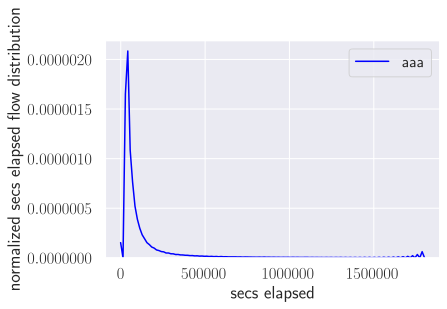

In [185]:
print("The mean and std of number of seconds per session are {} and {}, respectively.".format(sessions['secs_elapsed'].mean(),sessions['secs_elapsed'].std()))

sns.distplot(sessions[sessions['secs_elapsed'].notnull()]['secs_elapsed'], kde = True, bins = 200, color = "blue", hist = False, rug = False, label = 'aaa');
plt.xlabel('secs elapsed')
plt.ylabel('normalized secs elapsed flow distribution')
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

- mean is not a good candidate for replacing the Nans, as the distribution is highly skewed, and therefore, the mean is highly influenced by the outliers.

In [186]:
sessions['secs_elapsed'].describe()

count    1.017967e+07
mean     1.987866e+04
std      8.992588e+04
min      0.000000e+00
25%      2.630000e+02
50%      1.219000e+03
75%      8.911000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

In [187]:
sessions['secs_elapsed'] = sessions['secs_elapsed'].fillna(sessions['secs_elapsed'].median())

- After filling the Nans, we should check to see if the statistics got changed significantly. If so, that is not a good replacement.

In [188]:
sessions['secs_elapsed'].describe()

count    1.031520e+07
mean     1.963349e+04
std      8.935841e+04
min      0.000000e+00
25%      2.720000e+02
50%      1.219000e+03
75%      8.651000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

In [189]:
sessions.groupby('user_id')['secs_elapsed'].sum()

user_id
00023iyk9l     869115.0
0010k6l0om     587585.0
001wyh0pz8     282747.0
0028jgx1x1     298229.0
002qnbzfs5    6484841.0
                ...    
zzxox7jnrx     640655.0
zzy7t0y9cm      74990.0
zzysuoqg6x       2950.0
zzywmcn0jv    2151168.0
zzzlylp57e     432178.0
Name: secs_elapsed, Length: 135483, dtype: float64

In [190]:
sessions['device_type'].value_counts()

mac desktop                         3519243
windows desktop                     2597086
iphone                              2040096
android phone                        815732
ipad tablet                          668726
android app unknown phone/tablet     267799
other                                209533
tablet                               136244
linux desktop                         27653
chromebook                            22045
ipodtouch                              7958
windows phone                          2040
blackberry                              978
opera phone                              68
Name: device_type, dtype: int64

In [191]:
sessions['device_type'] = sessions['device_type'].replace('android app unknown phone/tablet', 'android app')
sessions['device_type'] = sessions['device_type'].replace('-unknown-', 'other')

In [192]:
sessions['device_type'].value_counts()

mac desktop        3519243
windows desktop    2597086
iphone             2040096
android phone       815732
ipad tablet         668726
android app         267799
other               209533
tablet              136244
linux desktop        27653
chromebook           22045
ipodtouch             7958
windows phone         2040
blackberry             978
opera phone             68
Name: device_type, dtype: int64

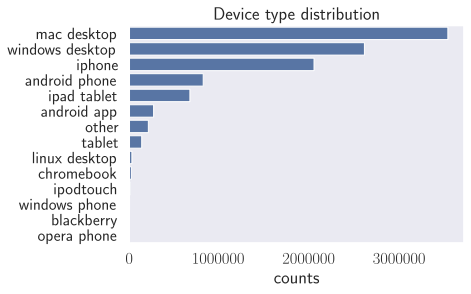

In [193]:
percentage = sessions['device_type'].value_counts() / sessions.shape[0]
sns.countplot(data = sessions, y = 'device_type', order = percentage.index, color = 'b')
plt.ylabel('')
plt.xlabel('counts')
plt.title('Device type distribution');
plt.grid(False)
plt.savefig('../figure/device_type_distribution', dpi = 300, bbox_inches = 'tight');

### Observation:
- Airbnb users tends to use Apple products more. Apple products (iPhone, iPad and the Mac) are among the top 5 most popular devices.

In [36]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10315201 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 550.9+ MB


In [37]:
sessions_user = pd.DataFrame()

In [38]:
sessions.groupby('user_id')['action'].value_counts()

user_id     action                     
00023iyk9l  show                           9
            requested                      5
            dashboard                      4
            index                          4
            personalize                    4
                                          ..
zzzlylp57e  create                         1
            lookup                         1
            message_to_host_focus          1
            other_hosting_reviews_first    1
            pending                        1
Name: action, Length: 1732721, dtype: int64

In [39]:
sessions_user['unique_action'] = sessions.groupby('user_id')['action'].nunique()

In [40]:
sessions_user['unique_action'].value_counts()

10    10289
9     10222
11     9784
8      9617
12     8662
      ...  
71        3
63        2
66        2
67        2
72        1
Name: unique_action, Length: 70, dtype: int64

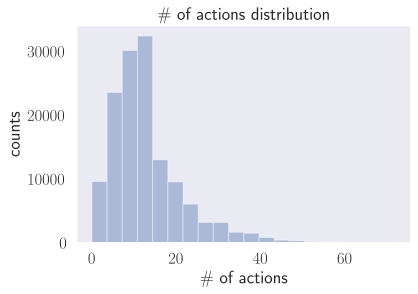

In [148]:
sns.distplot(sessions_user['unique_action'], kde = False, bins = 20, hist = True, rug = False);
plt.xlabel('\# of actions')
plt.ylabel('counts')
plt.title('\# of actions distribution');
plt.grid(False)
plt.savefig('../figure/action_distribution', dpi = 300, bbox_inches = 'tight');

In [42]:
sessions.groupby('user_id')['action_type'].value_counts()

user_id     action_type    
00023iyk9l  view               21
            data                9
            click               4
            booking_request     1
            message_post        1
                               ..
zzzlylp57e  data               17
            -unknown-           4
            submit              3
            booking_request     1
            message_post        1
Name: action_type, Length: 671364, dtype: int64

In [43]:
sessions_user['unique_action_type'] = sessions.groupby('user_id')['action_type'].nunique()

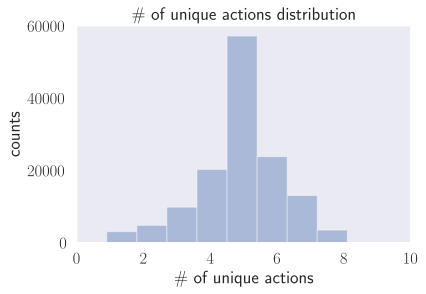

In [158]:
sns.distplot(sessions_user['unique_action_type'], kde = False, bins = 10, hist = True, rug = False);
plt.xlabel('\# of unique actions')
plt.ylabel('counts')
plt.title('\# of unique actions distribution');
plt.xlim(0,10)
plt.grid(False)
plt.savefig('../figure/unique_action_type_distribution', dpi = 300, bbox_inches = 'tight');

In [45]:
sessions.groupby('user_id')['action_detail'].value_counts()

user_id     action_detail          
00023iyk9l  p3                         6
            p5                         5
            view_search_results        5
            dashboard                  4
            wishlist_content_update    4
                                      ..
zzzlylp57e  create_user                1
            message_post               1
            message_to_host_focus      1
            pending                    1
            post_checkout_action       1
Name: action_detail, Length: 1508994, dtype: int64

In [46]:
sessions_user['unique_action_detail'] = sessions.groupby('user_id')['action_detail'].nunique()

In [47]:
sessions.groupby('user_id')['device_type'].value_counts()

user_id     device_type    
00023iyk9l  mac desktop        36
            iphone              4
0010k6l0om  mac desktop        62
001wyh0pz8  android app        89
0028jgx1x1  other              30
                               ..
zzxox7jnrx  windows desktop    89
zzy7t0y9cm  windows desktop     8
zzysuoqg6x  windows desktop     3
zzywmcn0jv  windows desktop    51
zzzlylp57e  windows desktop    73
Name: device_type, Length: 178236, dtype: int64

In [48]:
sessions_user['device_type'] = sessions.groupby('user_id')['device_type'].nunique()

In [49]:
sessions_user['device_type'].value_counts()

1    98962
2    31129
3     4649
4      652
5       85
6        6
Name: device_type, dtype: int64

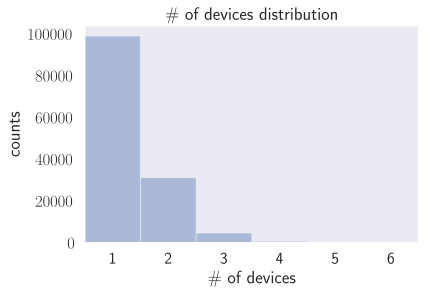

In [152]:
# xticks are not centered, so here is a piece of code to centerize them:
bins = range(1,8)
sns.distplot(sessions_user['device_type'], kde = False, bins = 5, hist = True, rug = False);
plt.xlabel('\# of devices')
plt.ylabel('counts')
plt.title('\# of devices distribution');
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins)
plt.xlim(bins[0], bins[-1])
plt.grid(False)

plt.savefig('../figure/unique_device_type_distribution', dpi = 300, bbox_inches = 'tight');

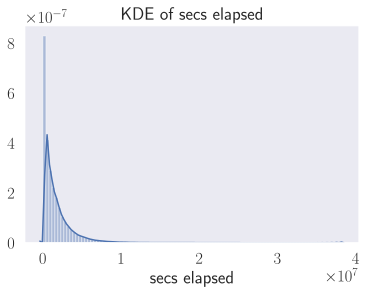

In [164]:
sns.distplot(sessions_user['secs_elapsed'], kde = True, bins = 100, hist = True, rug = False);
plt.xlabel('secs elapsed')
plt.ylabel('')
plt.title('KDE of secs elapsed');
plt.grid(False)
plt.savefig('../figure/secs_elapsed_distribution', dpi = 300, bbox_inches = 'tight');

In [52]:
sessions_user['secs_elapsed_mean'] = sessions.groupby('user_id')['secs_elapsed'].mean()

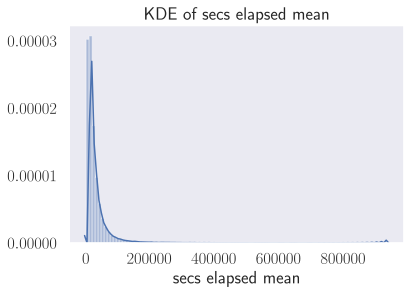

In [166]:
sns.distplot(sessions_user['secs_elapsed_mean'], kde = True, bins = 100, hist = True, rug = False);
plt.xlabel('secs elapsed mean')
plt.ylabel('')
plt.title('KDE of secs elapsed mean');
plt.grid(False)
plt.savefig('../figure/secs_elapsed_mean_distribution', dpi = 300, bbox_inches = 'tight');

In [54]:
sessions_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135483 entries, 00023iyk9l to zzzlylp57e
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   unique_action         135483 non-null  int64  
 1   unique_action_type    135483 non-null  int64  
 2   unique_action_detail  135483 non-null  int64  
 3   device_type           135483 non-null  int64  
 4   secs_elapsed          135483 non-null  float64
 5   secs_elapsed_mean     135483 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 7.2+ MB


### I'll merge sessions_user dataset to the train set later after completing EDA.

### EDA - agb dataset

In [55]:
agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [56]:
agb.shape
print("There exists {} observations and {} features in agb dataset. \n".format(agb.shape[0],agb.shape[1]))

There exists 420 observations and 5 features in agb dataset. 



In [57]:
agb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


In [58]:
agb.isnull().sum()

age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64

In [59]:
agb.duplicated().sum()

0

In [60]:
agb['country_destination'].value_counts()

CA    42
AU    42
GB    42
US    42
ES    42
DE    42
FR    42
NL    42
PT    42
IT    42
Name: country_destination, dtype: int64

### Observations - agb dataset:
- no missing value is observed.
- no duplicated value is observed.
- 'country_destination' column has the same values as train['country_destination'], except for 'other' and 'NDF'.

In [61]:
agb['gender'] = agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
agb['gender'].value_counts()

1    210
0    210
Name: gender, dtype: int64

In [62]:
agb['year'].describe()

count     420.0
mean     2015.0
std         0.0
min      2015.0
25%      2015.0
50%      2015.0
75%      2015.0
max      2015.0
Name: year, dtype: float64

### agb is collected all in 2015, therefore, 'year' column can be dropped.

In [63]:
agb.drop('year', axis = 1, inplace = True)

In [64]:
# let's deal with the age bucket, converting that to numerical variable by taking the average of the upper and lower bound seems to be a good idea.
agb['age_bucket'] = agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
agb['min_age'] = agb['age_bucket'].apply(lambda x: (int(x.split('-')[0])))
agb['max_age'] = agb['age_bucket'].apply(lambda x: (int(x.split('-')[1])))
agb['mean_age'] = (agb['min_age'] + agb['max_age']) / 2
agb.drop(['age_bucket', 'min_age', 'max_age'], axis=1, inplace = True)

### EDA - countries dataset

In [65]:
countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [66]:
countries.shape
print("There exists {} observations and {} features in countries dataset. \n".format(countries.shape[0],countries.shape[1]))

There exists 10 observations and 7 features in countries dataset. 



In [67]:
countries.isnull().sum()

country_destination              0
lat_destination                  0
lng_destination                  0
distance_km                      0
destination_km2                  0
destination_language             0
language_levenshtein_distance    0
dtype: int64

In [68]:
countries.duplicated().sum()

0

### Observations - countries dataset:
- no missing value is observed.
- no duplicated value is observed.
- 'country_destination' column has the same values as train['country_destination'], except for 'other' and 'NDF'.

In [69]:
import geopandas as gpd
import folium
from folium import plugins

In [70]:
map_ = folium.Map(tiles = 'OpenStreetMap')
countries_map = pd.DataFrame({"Lat": countries['lat_destination'],"Long": countries['lng_destination']})
map_.add_child(plugins.HeatMap(data = countries_map))
map_

### Now that I have some idea on what each dataset includes, let's start performing some preliminary EDA

- I will combine train and test dataset in order to have consistent data cleaning on both, then I will seperate them in the same way it was given originally --> on hold for Galvanize capstone 2

- I will call train dataset as df (to reserve the term for the combined train and test dataset as well)

In [71]:
# # 'country_destination' should be added to the test dataset. 
# # I will assign 'tbd' to it in order to split them from train dataset later.
# test['country_destination'] = 'tbd'

In [72]:
# df = pd.concat((train, test), axis = 0, ignore_index = True)
# print("There exists {} observations and {} features in the train-test combined dataset. \n".format(df.shape[0],df.shape[1]))

In [73]:
df = train

In [74]:
df = df.applymap(lambda s:s.lower() if type(s) == str else s)
# df['country_destination'] = df['country_destination'].str.upper() 

### EDA on 'country_destination'

In [75]:
# figsize = (16, 8)
# df[df['country_destination'] == 'OTHER'] = 'OTH'
# percentage = df['country_destination'].value_counts() / df.shape[0] * 100
# sns.countplot(data = df, x = 'country_destination', order = percentage.index, color = 'b')
# plt.xlabel('')
# plt.ylabel('counts')
# plt.ylim(0, 150000)
# plt.xticks(size = 12)
# plt.title('Country destination distribution');
# plt.grid(False)
# for i in range(percentage.shape[0]):
#     strt = '{:0.1f}%'.format(percentage[i])
#     plt.text(i, df['country_destination'].value_counts()[i] + 2000, strt, ha = 'center', size = 16)
    
# plt.savefig('../figure/country_destination_distribution_q1', dpi = 300, bbox_inches = 'tight');

### Observations:
- All the users in this dataset are from the USA, therefore, about 29% of users booked a reservation in their country.
- 58% of the users did not book at all (NDF)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [77]:
df.drop('date_first_booking', axis = 1, inplace = True)

In [78]:
df.duplicated().sum()

0

In [79]:
df.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                         0
age                        87990
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6065
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

### Observations - train-test combined dataset:
- I dropped 'date_first_booking', as it does not give any useful info.
- 'age' has missing value.
- 'first_affiliate_tracked' has missing value.
- no duplicated observations in train and test datasets is observed.

In [80]:
df.nunique()

id                         213451
date_account_created         1634
timestamp_first_active     213451
gender                          4
age                           127
signup_method                   3
signup_flow                    17
language                       25
affiliate_channel               8
affiliate_provider             18
first_affiliate_tracked         7
signup_app                      4
first_device_type               9
first_browser                  52
country_destination            12
dtype: int64

### EDA on 'age'

In [81]:
df['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

### Observations - age:
- 'age' seems to have outliers. I will focus on the 'age' between 18 and 100. However, having the maximum of 2014, some users may have entered some random year (at the time of signing up) or their birth year. Therefore, some of them can be retrieved and some of them should be dropped.

- They consists no more than 1% of the data.

In [82]:
df.loc[df['age'] > 100]['age'].count()

2345

In [83]:
df.loc[df['age'] < 18]['age'].count()

158

In [84]:
# since I am limiting the age to be less than 100, so I will retrieve the 'age's more than 1920 as I assume they have entered their birth year.
df.loc[df['age'] > 1920]['age'].count()

779

In [85]:
# the data was gathered in 2015, therefore:
index_age = df.loc[df['age'] > 1920]['age'].index
df.loc[index_age, 'age'] = 2015 - df.loc[index_age, 'age']

In [86]:
# sanity check
df.loc[df['age'] > 1920]['age'].count()

0

In [87]:
# dropping the rows with 'age' outliers
df.drop(df[(df['age'] < 18) | (df['age'] > 100)].index, inplace = True)

In [88]:
# replacing the Nans in 'age' with mean
df['age'].fillna(df['age'].mean(), inplace = True)

The mean and std of 'age' are 36.58524884743917 and 8.932068993642012, respectively.


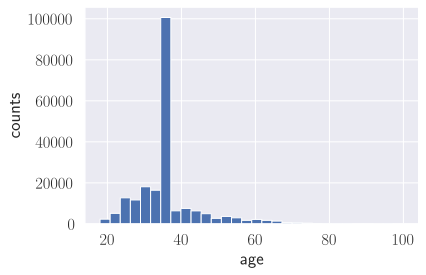

In [89]:
print("The mean and std of 'age' are {} and {}, respectively.".format(df['age'].mean(),df['age'].std()))
df['age'].hist(bins = 30);
plt.xlabel('age')
plt.ylabel('counts');

### EDA on 'gender'

In [90]:
df['gender'].value_counts()

-unknown-    94964
female       62023
male         53712
other          278
Name: gender, dtype: int64

In [91]:
# I will replace -unknown- with other
df['gender'].replace('-unknown-', 'other', inplace = True)

Text(0.5, 0, '')

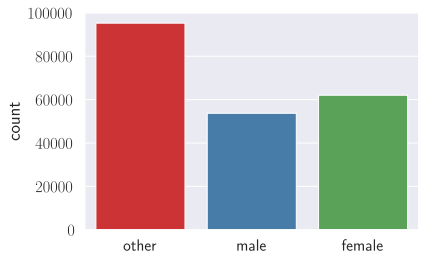

In [92]:
sns.countplot(df['gender'], palette = 'Set1');
plt.xlabel('')

### EDA on 'first_browser'

In [93]:
df['first_browser'].value_counts()

chrome                  63110
safari                  44571
firefox                 33227
-unknown-               27086
ie                      20783
mobile safari           19072
chrome mobile            1256
android browser           839
aol explorer              238
opera                     184
silk                      120
chromium                   72
blackberry browser         52
maxthon                    46
apple mail                 36
ie mobile                  36
sogou explorer             33
mobile firefox             29
rockmelt                   24
sitekiosk                  23
iron                       17
pale moon                  12
iceweasel                  12
yandex.browser             11
seamonkey                  11
cometbird                  11
camino                      9
tenfourfox                  8
wosbrowser                  6
coolnovo                    6
opera mini                  4
avant browser               4
mozilla                     3
crazy brow

In [94]:
# 'first_browser' data cleaning
df['first_browser'].replace('mobile safari', 'safari', inplace = True)
df['first_browser'].replace('chrome mobile', 'chrome', inplace = True)
df['first_browser'].replace('ie mobile', 'ie', inplace = True)
df['first_browser'].replace('firefox mobile', 'firefox', inplace = True)
temp = ['safari', 'chrome', 'ie', 'firefox']
index_temp = df.loc[~df['first_browser'].isin(temp)]['first_browser'].index
df.loc[index_temp, 'first_browser'] = 'other'

In [95]:
# sanity check
df['first_browser'].value_counts()

chrome     64366
safari     63643
firefox    33227
other      28922
ie         20819
Name: first_browser, dtype: int64

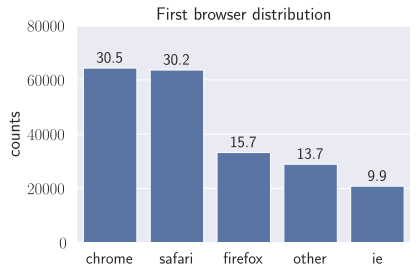

In [96]:
percentage = df['first_browser'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'first_browser', order = percentage.index, color = 'b')
plt.xlabel('')
plt.ylabel('counts')
plt.ylim(0, 80000)
plt.title('First browser distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['first_browser'].value_counts()[i] + 2000, strt, ha = 'center', size = 16)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on 'signup_method'

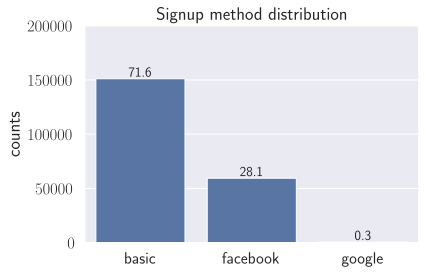

In [97]:
percentage = df['signup_method'].value_counts() / df.shape[0] * 100

sns.countplot(data = df, x = 'signup_method', order = percentage.index, color = 'b')
plt.xlabel('')
plt.ylabel('counts')
plt.ylim(0, 200000)
plt.title('Signup method distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['signup_method'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
plt.savefig('../figure/signup_method_distribution', bbox_inches = 'tight');

In [98]:
df['signup_flow'].describe()

count    210977.000000
mean          3.284600
std           7.656382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          25.000000
Name: signup_flow, dtype: float64

The mean and std of 'signup_flow' are 3.284599743099959 and 7.656381774922624, respectively.


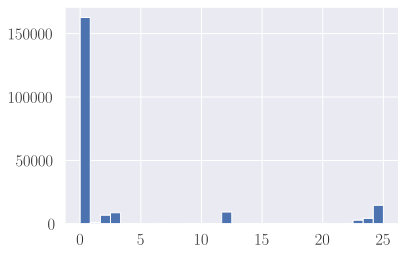

In [99]:
print("The mean and std of 'signup_flow' are {} and {}, respectively.".format(df['signup_flow'].mean(),df['signup_flow'].std()))
df['signup_flow'].hist(bins = 30);

In [100]:
# sns.distplot(df['signup_flow'], kde = True, bins = 200, color = "blue", hist = False, rug = False, label = 'aaa');
# plt.xlabel('signup flow')
# plt.ylabel('normalized signup flow distribution')
# # plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on 'language'

In [101]:
df['language'].value_counts()

en    203939
zh      1624
fr      1138
es       904
ko       739
de       728
it       506
ru       379
pt       235
ja       223
sv       121
nl        96
tr        64
da        58
pl        51
no        30
cs        30
el        24
th        23
id        22
hu        17
fi        14
ca         5
is         5
hr         2
Name: language, dtype: int64

In [102]:
index_temp = df.loc[df['language'] != 'en']['language'].index
df.loc[index_temp, 'language'] = 'other'

In [103]:
# sanity check
df['language'].value_counts()

en       203939
other      7038
Name: language, dtype: int64

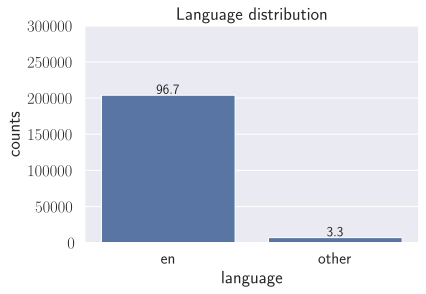

In [104]:
percentage = df['language'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'language', order = percentage.index, color = 'b')
plt.xlabel('language')
plt.ylabel('counts')
plt.ylim(0, 300000)
plt.title('Language distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['language'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on 'affiliate_channel'

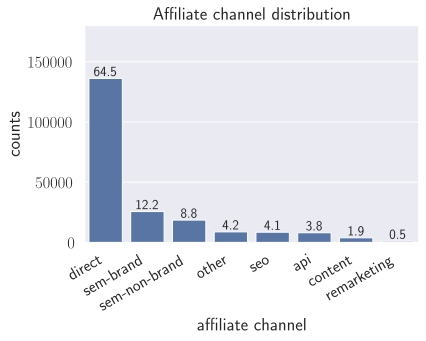

In [105]:
percentage = df['affiliate_channel'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'affiliate_channel', order = percentage.index, color = 'b')
plt.xlabel('affiliate channel')
plt.ylabel('counts')
plt.ylim(0, 180000)
plt.xticks(rotation = 30, horizontalalignment = 'right')
plt.title('Affiliate channel distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['affiliate_channel'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on 'affiliate_provider'

In [106]:
df['affiliate_provider'].value_counts()

direct                 135884
google                  51021
other                   12426
craigslist               3410
bing                     2304
facebook                 2259
vast                      821
padmapper                 758
facebook-open-graph       539
yahoo                     492
gsp                       450
meetup                    344
email-marketing           164
naver                      51
baidu                      29
yandex                     17
wayn                        7
daum                        1
Name: affiliate_provider, dtype: int64

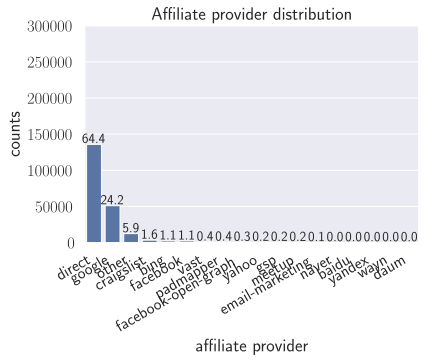

In [107]:
percentage = df['affiliate_provider'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'affiliate_provider', order = percentage.index, color = 'b')
plt.xlabel('affiliate provider')
plt.ylabel('counts')
plt.ylim(0, 300000)
plt.xticks(rotation = 30, horizontalalignment = 'right')
plt.title('Affiliate provider distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['affiliate_provider'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on 'affiliate_channel'

In [108]:
df['affiliate_channel'].value_counts()

direct           136180
sem-brand         25706
sem-non-brand     18605
other              8825
seo                8558
api                8111
content            3909
remarketing        1083
Name: affiliate_channel, dtype: int64

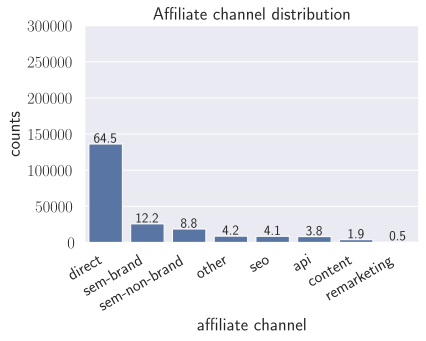

In [109]:
percentage = df['affiliate_channel'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'affiliate_channel', order = percentage.index, color = 'b')
plt.xlabel('affiliate channel')
plt.ylabel('counts')
plt.ylim(0, 300000)
plt.xticks(rotation = 30, horizontalalignment = 'right')

plt.title('Affiliate channel distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['affiliate_channel'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on 'first_affiliate_tracked'

In [110]:
df['first_affiliate_tracked'].value_counts()

untracked        108038
linked            45715
omg               43471
tracked-other      6058
product            1530
marketing           139
local ops            33
Name: first_affiliate_tracked, dtype: int64

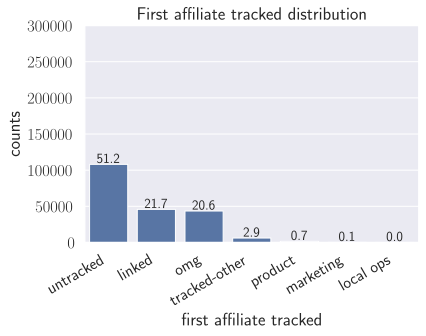

In [111]:
percentage = df['first_affiliate_tracked'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'first_affiliate_tracked', order = percentage.index, color = 'b')
plt.xlabel('first affiliate tracked')
plt.ylabel('counts')
plt.ylim(0, 300000)
plt.xticks(rotation = 30, horizontalalignment = 'right')
plt.title('First affiliate tracked distribution');

for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df['first_affiliate_tracked'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

### EDA on the cleaned train dataset

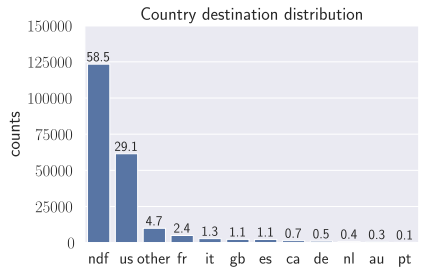

In [112]:
destination_percentage = df['country_destination'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'country_destination', order = destination_percentage.index, color = 'b')
plt.xlabel('')
plt.ylabel('counts')
plt.ylim(0, 150000)
plt.title('Country destination distribution');

for i in range(destination_percentage.shape[0]):
    strt = '{:0.1f}%'.format(destination_percentage[i])
    plt.text(i, df['country_destination'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
plt.savefig('../figure/country_destination_q1', bbox_inches = 'tight');

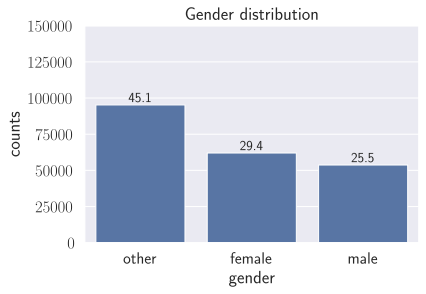

In [113]:
gender_percentage = df['gender'].value_counts() / df.shape[0] * 100
sns.countplot(data = df, x = 'gender', order = gender_percentage.index, color = 'b')
plt.xlabel('gender')
plt.ylabel('counts')
plt.ylim(0, 150000)
plt.title('Gender distribution');

for i in range(gender_percentage.shape[0]):
    strt = '{:0.1f}%'.format(gender_percentage[i])
    plt.text(i, df['gender'].value_counts()[i] + 2000, strt, ha = 'center', size = 14)
    
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

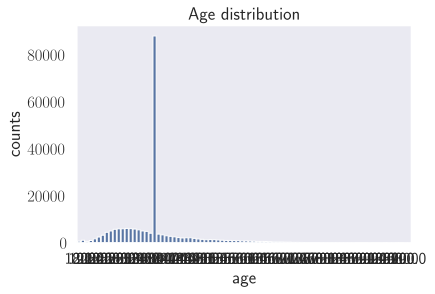

In [114]:
# sns.distplot(df['age'], kde = True, bins = 100, hist = True, rug = False)
sns.countplot(data = df, x = 'age', color = 'b')
plt.xlabel('age')
plt.ylabel('counts')
plt.title('Age distribution');
plt.grid(False)
plt.savefig('../figure/age_distribution', dpi = 300, bbox_inches = 'tight');

In [115]:
unique, counts = np.unique(df['country_destination'], return_counts=True)
def stacked_bar(feature):
    ctab = pd.crosstab(df[feature], df['country_destination'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[unique].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

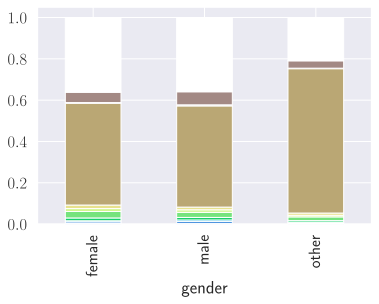

In [116]:
stacked_bar('gender')

In [117]:
unique

array(['au', 'ca', 'de', 'es', 'fr', 'gb', 'it', 'ndf', 'nl', 'other',
       'pt', 'us'], dtype=object)

In [118]:
df['signup_method'].isnull().sum()

0

#### Merging 'secs_elapsed' from sessions dataset to the train dataset:

In [119]:
result1 = pd.merge(df, sessions.groupby('user_id').sum(), 
                  left_on='id', right_on='user_id', how='inner')

In [120]:
result1['country_destination'].value_counts()

ndf      44697
us       19826
other     3591
fr        1417
it         962
gb         716
es         695
ca         434
de         247
nl         244
au         150
pt          82
Name: country_destination, dtype: int64

In [121]:
result1.shape

(73061, 16)

In [122]:
result1.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72761 entries, 0 to 73060
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       72761 non-null  object 
 1   date_account_created     72761 non-null  object 
 2   timestamp_first_active   72761 non-null  int64  
 3   gender                   72761 non-null  object 
 4   age                      72761 non-null  float64
 5   signup_method            72761 non-null  object 
 6   signup_flow              72761 non-null  int64  
 7   language                 72761 non-null  object 
 8   affiliate_channel        72761 non-null  object 
 9   affiliate_provider       72761 non-null  object 
 10  first_affiliate_tracked  72761 non-null  object 
 11  signup_app               72761 non-null  object 
 12  first_device_type        72761 non-null  object 
 13  first_browser            72761 non-null  object 
 14  country_destination   

In [123]:
result2 = pd.merge(df, sessions_user, left_on='id', right_on='user_id', how='outer')

In [124]:
result2 = result2.loc[train['id'].index]

In [125]:
# sanity check
result2.shape, train.shape

((213451, 21), (213451, 16))

In [126]:
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       210977 non-null  object 
 1   date_account_created     210977 non-null  object 
 2   timestamp_first_active   210977 non-null  float64
 3   gender                   210977 non-null  object 
 4   age                      210977 non-null  float64
 5   signup_method            210977 non-null  object 
 6   signup_flow              210977 non-null  float64
 7   language                 210977 non-null  object 
 8   affiliate_channel        210977 non-null  object 
 9   affiliate_provider       210977 non-null  object 
 10  first_affiliate_tracked  204984 non-null  object 
 11  signup_app               210977 non-null  object 
 12  first_device_type        210977 non-null  object 
 13  first_browser            210977 non-null  object 
 14  coun

In [127]:
result2.dropna(inplace = True)
result2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72761 entries, 135309 to 210976
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       72761 non-null  object 
 1   date_account_created     72761 non-null  object 
 2   timestamp_first_active   72761 non-null  float64
 3   gender                   72761 non-null  object 
 4   age                      72761 non-null  float64
 5   signup_method            72761 non-null  object 
 6   signup_flow              72761 non-null  float64
 7   language                 72761 non-null  object 
 8   affiliate_channel        72761 non-null  object 
 9   affiliate_provider       72761 non-null  object 
 10  first_affiliate_tracked  72761 non-null  object 
 11  signup_app               72761 non-null  object 
 12  first_device_type        72761 non-null  object 
 13  first_browser            72761 non-null  object 
 14  country_destinat

In [128]:
result2['secs_elapsed'].isnull().sum()

0

In [129]:
result2['secs_elapsed'].describe()

count    7.276100e+04
mean     1.518263e+06
std      1.913062e+06
min      1.219000e+03
25%      2.605060e+05
50%      8.775820e+05
75%      2.049486e+06
max      3.808384e+07
Name: secs_elapsed, dtype: float64

The mean and std of number of seconds per session are 1518263.1793268372 and 1913062.482621521, respectively.


Text(0, 0.5, 'normalized secs elapsed flow distribution')

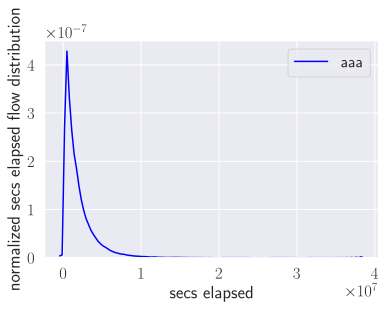

In [130]:
print("The mean and std of number of seconds per session are {} and {}, respectively.".format(result2['secs_elapsed'].mean(),result2['secs_elapsed'].std()))

sns.distplot(result2[result2['secs_elapsed'].notnull()]['secs_elapsed'], kde = True, bins = 200, color = "blue", hist = False, rug = False, label = 'aaa');
plt.xlabel('secs elapsed')
plt.ylabel('normalized secs elapsed flow distribution')
# plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

In [131]:
result2.describe()

,timestamp_first_active,age,signup_flow,unique_action,unique_action_type,unique_action_detail,device_type,secs_elapsed,secs_elapsed_mean
count,7.276100e+04,72761.000000,72761.000000,72761.000000,72761.000000,72761.000000,72761.000000,7.276100e+04,72761.000000
mean,2.014040e+13,35.845003,4.818323,12.574346,4.903726,10.875854,1.314647,1.518263e+06,29102.674541
std,1.710547e+08,8.748636,9.319451,7.985971,1.462161,5.952328,0.558783,1.913062e+06,43294.878903
min,2.014010e+13,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.219000e+03,296.142857
25%,2.014023e+13,31.000000,0.000000,7.000000,4.000000,7.000000,1.000000,2.605060e+05,9007.751174
50%,2.014042e+13,36.585249,0.000000,11.000000,5.000000,10.000000,1.000000,8.775820e+05,17476.317073
75%,2.014053e+13,36.585249,0.000000,16.000000,6.000000,14.000000,2.000000,2.049486e+06,33160.269231
max,2.014063e+13,100.000000,25.000000,71.000000,8.000000,46.000000,6.000000,3.808384e+07,931765.000000


In [132]:
# result2['secs_elapsed'].describe()

In [133]:
# print("The mean and std of number of seconds per session are {} and {}, respectively.".format(result2['secs_elapsed'].mean(),result2['secs_elapsed'].std()))

# sns.distplot(result2[result2['secs_elapsed'].notnull()]['secs_elapsed'], kde = True, bins = 200, color = "blue", hist = False, rug = False, label = 'aaa');
# plt.xlabel('secs elapsed')
# plt.ylabel('normalized secs elapsed flow distribution')
# # plt.savefig('../figure/normalized_column_name', bbox_inches = 'tight');

In [134]:
# a = np.nanpercentile(result2['secs_elapsed'], 25)
# result2['secs_elapsed'] = result2['secs_elapsed'].fillna(a)

In [135]:
# standardscaling of the columns
from sklearn.preprocessing import StandardScaler
col_sc = ['secs_elapsed', 'secs_elapsed_mean']
sc = StandardScaler()
features = result2[col_sc]
sc = StandardScaler().fit(result2[col_sc].values)
result2[col_sc] = sc.transform(result2[col_sc].values)

In [136]:
result2.describe()

,timestamp_first_active,age,signup_flow,unique_action,unique_action_type,unique_action_detail,device_type,secs_elapsed,secs_elapsed_mean
count,7.276100e+04,72761.000000,72761.000000,72761.000000,72761.000000,72761.000000,72761.000000,7.276100e+04,7.276100e+04
mean,2.014040e+13,35.845003,4.818323,12.574346,4.903726,10.875854,1.314647,3.906174e-18,-2.031210e-17
std,1.710547e+08,8.748636,9.319451,7.985971,1.462161,5.952328,0.558783,1.000007e+00,1.000007e+00
min,2.014010e+13,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.929979e-01,-6.653611e-01
25%,2.014023e+13,31.000000,0.000000,7.000000,4.000000,7.000000,1.000000,-6.574620e-01,-4.641441e-01
50%,2.014042e+13,36.585249,0.000000,11.000000,5.000000,10.000000,1.000000,-3.349005e-01,-2.685407e-01
75%,2.014053e+13,36.585249,0.000000,16.000000,6.000000,14.000000,2.000000,2.776838e-01,9.372061e-02
max,2.014063e+13,100.000000,25.000000,71.000000,8.000000,46.000000,6.000000,1.911377e+01,2.084931e+01


In [137]:
result2.to_csv('../data/cleaned_airbnb_sessions.csv',  header=True)

## Hypothesis Testing:

- I would like to determine if there is statistically significant difference for the mean number of first booking in the following groups:

### Male vs. female
- Question: Is 'gender' statistically significant in determining whether or not a user will book his/her first reservation?
- Assumptiomns:
- I redefine the target variable as '0: did not book their first reservation' (corresponding to 'ndf' value in  and 'country_destination' column, and  '1: booked their first reservation' (corresponding to the rest of the values in 'country_destination' column).
- I consider only male and female users, no benefit to consider 'other' group.
- Null hypothesis: The mean number of first booking in male and female are not significantly different.
- Alternative hyphothesis: The mean number of first booking in male and female are significantly different.
- alpha value = 0.05
- p_value needs to be calculated and compared with alpha value

In [138]:
# Chi-Square test

df_temp = df[(df['gender'] != 'other') & (df['gender'].notnull())]
df_temp['gender'] = df_temp['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_temp = df_temp[['id', 'gender', 'country_destination']]
df_temp = df_temp.pivot_table('id', ['gender'], 'country_destination', aggfunc = 'count').reset_index()
df_temp = df_temp.set_index('gender')
chi2, p, dof, expected = stats.chi2_contingency(df_temp)
print(p)
if p < 0.05:
    print('The mean number of first booking in male and female are not significantly different.')
else:
    print('The mean number of first booking in male and female are significantly different.')

1.556141872387293e-39
The mean number of first booking in male and female are not significantly different.


In [139]:
# df['gender'] = df['gender'].apply(lambda x: 0 if x == 'male' else (1 if x == 'female' else 2))

In [140]:
# Welch’s t-test

temp_df = df[(df['gender'] != 2) & (df['gender'].notnull())]
temp_df['country_destination'] = temp_df['country_destination'].apply(lambda x: 0 if x == 'ndf' else 1)
temp_df = temp_df[['id', 'gender', 'country_destination']]
# temp_df = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc = 'count').reset_index()
# temp_df = observed.set_index('id')
df_male = temp_df[temp_df['gender'] == 0]
df_female = temp_df[temp_df['gender'] == 1]

stat, p_val = stats.ttest_ind(df_male['country_destination'], df_female['country_destination'], equal_var = False)
# del df_male, df_female
print(p_val)
if p_val < 0.05:
    print('The mean number of first booking in male and female are not significantly different.')
else:
    print('The mean number of first booking in male and female are significantly different.')

nan
The mean number of first booking in male and female are significantly different.


In [141]:
temp_df['gender'].value_counts()

other     95242
female    62023
male      53712
Name: gender, dtype: int64

## Hypothesis Testing:

- I would like to determine if there is statistically significant difference for the first destination in the following groups:

### Male vs. female
- Question: Is 'gender' statistically significant in determining the first destination of the users?
- Assumptiomns:
- For this purpose, I will only consider the 'country_destination != 'ndf'
- I consider only male and female users, no benefit to consider 'other' group.
- Null hypothesis: User gender and first destination booking are independent.
- Alternative hyphothesis: User gender and first destination booking are not independent.
- alpha value = 0.05
- p_value needs to be calculated and compared with alpha value

In [142]:
# Chi-Square test
df_temp = df[(df['country_destination'] != 'ndf') & (df['gender'] != 2) & (df['gender'].notnull())]
df_temp = df_temp[['id', 'gender', 'country_destination']]
df_temp = df_temp.pivot_table('id', ['gender'], 'country_destination', aggfunc = 'count').reset_index()
df_temp = df_temp.set_index('gender')
chi2, p, dof, expected = stats.chi2_contingency(df_temp)
print(p)
if p < 0.05:
    print('User gender and first destination booking are independent.')
else:
    print('User gender and first destination booking are not independent.')

2.029583837180843e-48
User gender and first destination booking are independent.


### Observations:
- There is a relationship between user gender and first destination. I will take into account while doing feature engineering.

- we will try to discover a relationship between the signup method and the signup device. A preliminary querying of our dataframe tells us that most users signup either through the standard basic method or through Facebook. Additionally, they login using either a desktop browser, a mobile browser or a mobile app.
- We will ignore the Google Signup Method as there are extremely few instances of it.
- We will consider iOs, Moweb and Android to all be of the Mobile Device Type.

In [143]:
df_signup = train[(train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


- Null Hypothesis: There is no relationship between device type and signup method.

In [144]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc = 'count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


### Conclusion Remarks

- There is no relationship between device type and signup method. The two variables are independent of each other.

In [145]:
df.to_csv('../data/cleaned_airbnb.csv', header = True)